<a href="https://colab.research.google.com/github/mithunmc/Image-Processing-Basics/blob/main/Lane_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [80]:
import numpy as np
import pandas as pd
import cv2 as cv 
from google.colab.patches import cv2_imshow # for image display
from skimage import io
from PIL import Image 
from PIL import ImageFilter
import matplotlib.pylab as plt
from scipy import ndimage
from skimage import *

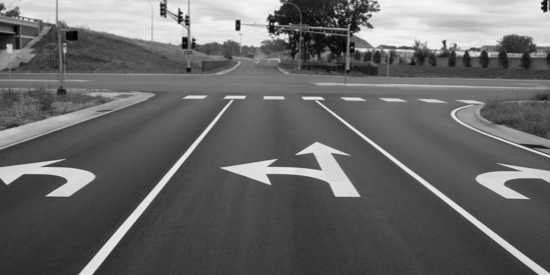

In [81]:
road1 = cv.imread("lane.jpg")
road = cv.cvtColor(road1, cv.COLOR_RGB2GRAY)
cv2_imshow(road)

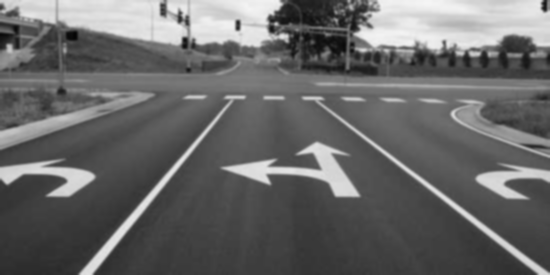

In [82]:

image = cv.GaussianBlur(road, (5, 5), 0)
cv2_imshow(image)  
# Using cv2.blur() method 


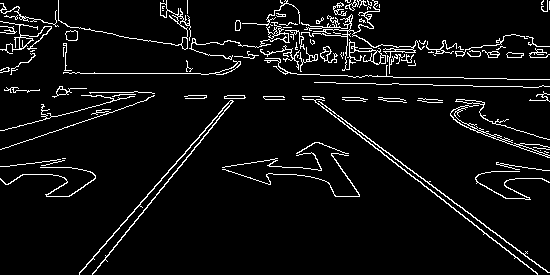

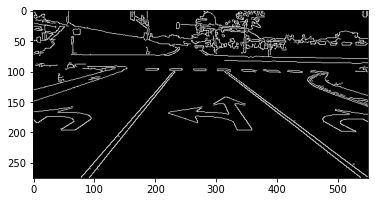

In [83]:
edge = cv.Canny(road,80,300)
cv2_imshow(edge)
plt.imshow(edge, cmap='gray')

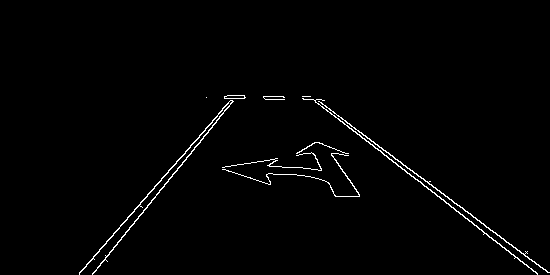

In [84]:
def region_of_interest(img, vertices):
  mask = np.zeros_like(img)
  if len(img.shape) > 2:
    channel_count = img.shape[2]
    print(channel_count)
    ignore_mask_color = (255,) * channel_count
  else:
    ignore_mask_color = 255
  cv.fillPoly(mask, vertices, ignore_mask_color)
  masked_image = cv.bitwise_and(img, mask)
  return masked_image

lowerLeftPoint = [40, 300]
upperLeftPoint = [220, 80]
upperRightPoint = [330, 100]
lowerRightPoint = [620, 300]
pts = np.array([[lowerLeftPoint, upperLeftPoint, upperRightPoint,lowerRightPoint]], dtype=np.int32)
masked_image = region_of_interest(edge, pts)
cv2_imshow(masked_image)

[[[ 92 274 237  95]]

 [[310  96 537 273]]

 [[317  99 547 272]]

 [[ 79 273 234  95]]

 [[318 101 418 176]]

 [[ 92 273 236  95]]

 [[308  96 520 261]]

 [[ 79 274 235  95]]

 [[316  99 513 247]]]


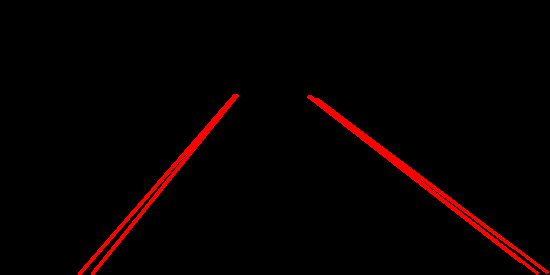

In [85]:
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
  lines = cv.HoughLinesP(img, rho, theta, threshold, np.array([]),minLineLength=min_line_len, maxLineGap=max_line_gap)
  line_img = np.zeros((*img.shape, 3), dtype=np.uint8)  
  draw_lines(line_img, lines)
  return line_img

def draw_lines(img, lines, color=[0, 0, 255], thickness=2):
  print(lines)
  for line in lines:
    for x1,y1,x2,y2 in line:
      cv.line(img, (x1, y1), (x2, y2), color, thickness)

rho = 1
theta = np.pi/180
threshold = 50
min_line_len = 50 
max_line_gap = 60

hough_transform = hough_lines(masked_image, rho, theta, 
                  threshold, min_line_len, max_line_gap)

cv2_imshow(hough_transform)

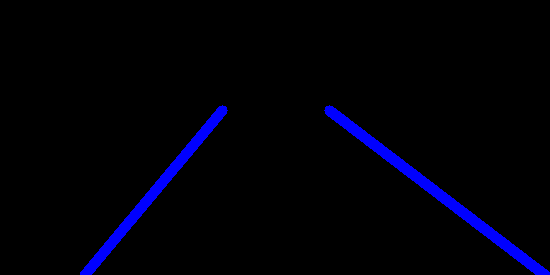

In [86]:
def display_lines(image, lines):
	line_image = np.zeros_like(image)
	if lines is not None:
		for x1, y1, x2, y2 in lines:
			cv.line(line_image, (x1, y1), (x2, y2), (255, 0, 0), 10)
	return line_image

def create_coordinates(image, line_parameters):
	slope, intercept = line_parameters
	y1 = image.shape[0]
	y2 = int(y1 * (2 / 5))
	x1 = int((y1 - intercept) / slope)
	x2 = int((y2 - intercept) / slope)
	return np.array([x1, y1, x2, y2])

def average_slope_intercept(image, lines):
	left_fit = []
	right_fit = []
	for line in lines:
		x1, y1, x2, y2 = line.reshape(4)
		
		# It will fit the polynomial and the intercept and slope
		parameters = np.polyfit((x1, x2), (y1, y2), 1)
		slope = parameters[0]
		intercept = parameters[1]
		if slope < 0:
			left_fit.append((slope, intercept))
		else:
			right_fit.append((slope, intercept))
			
	left_fit_average = np.average(left_fit, axis = 0)
	right_fit_average = np.average(right_fit, axis = 0)
	left_line = create_coordinates(image, left_fit_average)
	right_line = create_coordinates(image, right_fit_average)
	return np.array([left_line, right_line])
 
lines = cv.HoughLinesP(masked_image, rho, theta, threshold, np.array([]),minLineLength=min_line_len, maxLineGap=max_line_gap)
averaged_lines = average_slope_intercept(road1, lines) 
line_image = display_lines(road1, averaged_lines)
cv2_imshow(line_image)

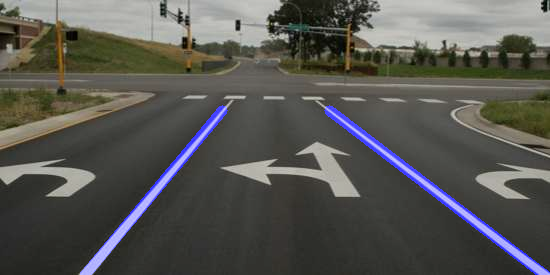

In [89]:
def weighted_img(img, initial_img, α=0.8, β=1, λ=0):
  return cv.addWeighted(initial_img, α, img, β, λ)

colored_image = weighted_img(line_image, road1)

cv2_imshow(colored_image)
